In [1]:
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
from dragonn.simulations import *

In [4]:
import tensorflow as tf

In [6]:
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [7]:
import keras

Using TensorFlow backend.


In [8]:
from keras.models import Sequential
from keras.layers import Dropout, Reshape, Dense, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop
import keras.losses
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K
K.set_image_data_format('channels_last')

In [9]:
from dragonn.vis import *

In [10]:
from dragonn.callbacks import *

In [11]:
from dragonn.utils import *

In [12]:
from dragonn.interpret.ism import *

In [13]:
from dragonn.interpret.input_grad import *

In [14]:
from dragonn.interpret.deeplift import *

In [15]:
from keras.models import load_model

In [16]:
print_simulation_info("simulate_motif_density_localization")


    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

In [17]:
motif_density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1500,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4,
    "num_pos": 3000,
    "num_neg": 3000,
    "GC_fraction": 0.4
}

In [18]:
simulation_data = get_simulation_data("simulate_motif_density_localization",
                                      motif_density_localization_simulation_parameters,
                                      validation_set_size=1000,
                                      test_set_size=1000)

In [19]:
print(simulation_data.X_train.shape, simulation_data.y_train.shape)

(4000, 1, 1500, 4) (4000, 1)


In [20]:
print(simulation_data.X_test.shape, simulation_data.y_test.shape)

(1000, 1, 1500, 4) (1000, 1)


In [21]:
print(simulation_data.X_valid.shape, simulation_data.y_valid.shape)

(1000, 1, 1500, 4) (1000, 1)


In [22]:
one_filter_keras_model = Sequential()
one_filter_keras_model.add(
    Conv2D(filters=1, kernel_size=(1,10), padding="same", input_shape=simulation_data.X_train.shape[1::])
)
one_filter_keras_model.add(BatchNormalization(axis=-1))
one_filter_keras_model.add(Activation('relu'))
one_filter_keras_model.add(MaxPooling2D(pool_size=(1, 35)))
one_filter_keras_model.add(Flatten())
one_filter_keras_model.add(Dense(1))
one_filter_keras_model.add(Activation("sigmoid"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [23]:
one_filter_keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1500, 1)        41        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1500, 1)        4         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1500, 1)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 42, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                

In [24]:
one_filter_keras_model.compile(optimizer="adam", loss="binary_crossentropy")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
metrics_callback = MetricsCallback(train_data=(simulation_data.X_train, simulation_data.y_train),
                                  validation_data=(simulation_data.X_valid, simulation_data.y_valid))

In [26]:
history_one_filter = one_filter_keras_model.fit(x=simulation_data.X_train,
                                               y=simulation_data.y_train,
                                               batch_size=128,
                                               epochs=150,
                                               verbose=1,
                                               callbacks=[EarlyStopping(patience=10, restore_best_weights=True),
                                                         History(),
                                                         metrics_callback],
                                               validation_data=(simulation_data.X_valid, simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - 1s 233us/step - loss: 1.0344 - val_loss: 0.7057
Training Data:
Loss: 0.7220	Balanced Accuracy: 48.44%	 auROC: 0.479	 auPRC Careful: 0.487	 auPRC Trapezoidal: 0.487
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.7057	Balanced Accuracy: 51.93%	 auROC: 0.512	 auPRC Careful: 0.498	 auPRC Trapezoidal: 0.497
	Recall at 5%|10%|20% FDR: 1.5%|1.5%|1.5%	 Num Positives: 481	 Num Negatives: 519
Epoch 2/150
4000/4000 [==============================] - 1s 191us/step - loss: 0.7494 - val_loss: 0.7093
Training Data:
Loss: 0.7188	Balanced Accuracy: 49.07%	 auROC: 0.485	 auPRC Careful: 0.492	 auPRC Trapezoidal: 0.491
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.7093	Balanced Accuracy: 51.77%	 auROC: 0.518	 auPRC Careful: 0.501	 auPRC Trapezoidal: 0.500
	Recall at 5%|10%|20% F

4000/4000 [==============================] - 1s 187us/step - loss: 0.6940 - val_loss: 0.6888
Training Data:
Loss: 0.6933	Balanced Accuracy: 52.95%	 auROC: 0.539	 auPRC Careful: 0.539	 auPRC Trapezoidal: 0.538
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6888	Balanced Accuracy: 54.25%	 auROC: 0.561	 auPRC Careful: 0.538	 auPRC Trapezoidal: 0.536
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|1.2%	 Num Positives: 481	 Num Negatives: 519
Epoch 18/150
4000/4000 [==============================] - 1s 192us/step - loss: 0.6936 - val_loss: 0.6868
Training Data:
Loss: 0.6923	Balanced Accuracy: 53.09%	 auROC: 0.541	 auPRC Careful: 0.542	 auPRC Trapezoidal: 0.542
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6868	Balanced Accuracy: 53.84%	 auROC: 0.562	 auPRC Careful: 0.538	 auPRC Trapezoidal: 0.537
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|1.0%	 Num Positives: 481	 Num Negatives: 519
E

4000/4000 [==============================] - 1s 187us/step - loss: 0.6887 - val_loss: 0.6867
Training Data:
Loss: 0.6876	Balanced Accuracy: 53.83%	 auROC: 0.562	 auPRC Careful: 0.563	 auPRC Trapezoidal: 0.563
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.4%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6867	Balanced Accuracy: 55.07%	 auROC: 0.572	 auPRC Careful: 0.554	 auPRC Trapezoidal: 0.553
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|1.5%	 Num Positives: 481	 Num Negatives: 519
Epoch 35/150
4000/4000 [==============================] - 1s 191us/step - loss: 0.6881 - val_loss: 0.6845
Training Data:
Loss: 0.6873	Balanced Accuracy: 54.62%	 auROC: 0.562	 auPRC Careful: 0.563	 auPRC Trapezoidal: 0.563
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|0.4%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6845	Balanced Accuracy: 55.59%	 auROC: 0.574	 auPRC Careful: 0.557	 auPRC Trapezoidal: 0.556
	Recall at 5%|10%|20% FDR: 1.0%|1.0%|1.7%	 Num Positives: 481	 Num Negatives: 519
E

4000/4000 [==============================] - 1s 186us/step - loss: 0.6851 - val_loss: 0.6802
Training Data:
Loss: 0.6846	Balanced Accuracy: 55.33%	 auROC: 0.575	 auPRC Careful: 0.577	 auPRC Trapezoidal: 0.577
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|1.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6802	Balanced Accuracy: 56.82%	 auROC: 0.595	 auPRC Careful: 0.572	 auPRC Trapezoidal: 0.571
	Recall at 5%|10%|20% FDR: 1.0%|1.0%|1.7%	 Num Positives: 481	 Num Negatives: 519
Epoch 52/150
4000/4000 [==============================] - 1s 191us/step - loss: 0.6847 - val_loss: 0.6814
Training Data:
Loss: 0.6840	Balanced Accuracy: 54.83%	 auROC: 0.576	 auPRC Careful: 0.578	 auPRC Trapezoidal: 0.578
	Recall at 5%|10%|20% FDR: 0.3%|0.4%|0.5%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6814	Balanced Accuracy: 56.41%	 auROC: 0.597	 auPRC Careful: 0.574	 auPRC Trapezoidal: 0.573
	Recall at 5%|10%|20% FDR: 1.0%|1.0%|1.7%	 Num Positives: 481	 Num Negatives: 519
E

4000/4000 [==============================] - 1s 208us/step - loss: 0.6796 - val_loss: 0.6796
Training Data:
Loss: 0.6778	Balanced Accuracy: 56.47%	 auROC: 0.598	 auPRC Careful: 0.602	 auPRC Trapezoidal: 0.601
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|4.3%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6796	Balanced Accuracy: 56.99%	 auROC: 0.600	 auPRC Careful: 0.569	 auPRC Trapezoidal: 0.568
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|1.2%	 Num Positives: 481	 Num Negatives: 519
Epoch 69/150
4000/4000 [==============================] - 1s 198us/step - loss: 0.6790 - val_loss: 0.6778
Training Data:
Loss: 0.6777	Balanced Accuracy: 56.82%	 auROC: 0.599	 auPRC Careful: 0.602	 auPRC Trapezoidal: 0.602
	Recall at 5%|10%|20% FDR: 0.1%|0.6%|4.7%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6778	Balanced Accuracy: 57.60%	 auROC: 0.600	 auPRC Careful: 0.568	 auPRC Trapezoidal: 0.566
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|1.0%	 Num Positives: 481	 Num Negatives: 519
E

4000/4000 [==============================] - 1s 187us/step - loss: 0.6705 - val_loss: 0.6740
Training Data:
Loss: 0.6687	Balanced Accuracy: 58.30%	 auROC: 0.625	 auPRC Careful: 0.626	 auPRC Trapezoidal: 0.625
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|1.7%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6740	Balanced Accuracy: 59.72%	 auROC: 0.617	 auPRC Careful: 0.579	 auPRC Trapezoidal: 0.578
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|0.8%	 Num Positives: 481	 Num Negatives: 519
Epoch 86/150
4000/4000 [==============================] - 1s 197us/step - loss: 0.6691 - val_loss: 0.6745
Training Data:
Loss: 0.6678	Balanced Accuracy: 58.33%	 auROC: 0.627	 auPRC Careful: 0.627	 auPRC Trapezoidal: 0.627
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|2.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6745	Balanced Accuracy: 58.73%	 auROC: 0.615	 auPRC Careful: 0.576	 auPRC Trapezoidal: 0.575
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|0.8%	 Num Positives: 481	 Num Negatives: 519
E

4000/4000 [==============================] - 1s 236us/step - loss: 0.6674 - val_loss: 0.6762
Training Data:
Loss: 0.6675	Balanced Accuracy: 57.68%	 auROC: 0.629	 auPRC Careful: 0.630	 auPRC Trapezoidal: 0.630
	Recall at 5%|10%|20% FDR: 0.0%|1.3%|1.8%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6762	Balanced Accuracy: 58.68%	 auROC: 0.615	 auPRC Careful: 0.574	 auPRC Trapezoidal: 0.572
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|0.6%	 Num Positives: 481	 Num Negatives: 519
Epoch 103/150
4000/4000 [==============================] - 1s 273us/step - loss: 0.6679 - val_loss: 0.6764
Training Data:
Loss: 0.6667	Balanced Accuracy: 58.19%	 auROC: 0.631	 auPRC Careful: 0.631	 auPRC Trapezoidal: 0.631
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|2.6%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6764	Balanced Accuracy: 58.37%	 auROC: 0.614	 auPRC Careful: 0.573	 auPRC Trapezoidal: 0.572
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|0.6%	 Num Positives: 481	 Num Negatives: 519


Training Data:
Loss: 0.6560	Balanced Accuracy: 60.88%	 auROC: 0.653	 auPRC Careful: 0.650	 auPRC Trapezoidal: 0.649
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|4.8%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6682	Balanced Accuracy: 60.81%	 auROC: 0.630	 auPRC Careful: 0.590	 auPRC Trapezoidal: 0.589
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|3.5%	 Num Positives: 481	 Num Negatives: 519
Epoch 119/150
4000/4000 [==============================] - 1s 210us/step - loss: 0.6575 - val_loss: 0.6678
Training Data:
Loss: 0.6555	Balanced Accuracy: 61.16%	 auROC: 0.654	 auPRC Careful: 0.651	 auPRC Trapezoidal: 0.651
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|7.8%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6678	Balanced Accuracy: 61.09%	 auROC: 0.630	 auPRC Careful: 0.591	 auPRC Trapezoidal: 0.589
	Recall at 5%|10%|20% FDR: 0.4%|2.9%|3.5%	 Num Positives: 481	 Num Negatives: 519
Epoch 120/150
4000/4000 [==============================] - 1s 208us/step - loss: 0.6562 - val

4000/4000 [==============================] - 1s 208us/step - loss: 0.6468 - val_loss: 0.6610
Training Data:
Loss: 0.6452	Balanced Accuracy: 63.00%	 auROC: 0.675	 auPRC Careful: 0.669	 auPRC Trapezoidal: 0.669
	Recall at 5%|10%|20% FDR: 0.2%|0.7%|8.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6610	Balanced Accuracy: 62.76%	 auROC: 0.645	 auPRC Careful: 0.613	 auPRC Trapezoidal: 0.612
	Recall at 5%|10%|20% FDR: 2.5%|3.1%|4.2%	 Num Positives: 481	 Num Negatives: 519
Epoch 136/150
4000/4000 [==============================] - 1s 222us/step - loss: 0.6454 - val_loss: 0.6608
Training Data:
Loss: 0.6444	Balanced Accuracy: 62.93%	 auROC: 0.677	 auPRC Careful: 0.670	 auPRC Trapezoidal: 0.670
	Recall at 5%|10%|20% FDR: 0.2%|1.1%|8.2%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6608	Balanced Accuracy: 63.04%	 auROC: 0.646	 auPRC Careful: 0.616	 auPRC Trapezoidal: 0.615
	Recall at 5%|10%|20% FDR: 2.9%|3.3%|4.6%	 Num Positives: 481	 Num Negatives: 519


In [27]:
test_predictions = one_filter_keras_model.predict(simulation_data.X_test)

In [28]:
print(ClassificationResult(simulation_data.y_test, test_predictions))

Loss: 0.6499	Balanced Accuracy: 61.60%	 auROC: 0.660	 auPRC Careful: 0.665	 auPRC Trapezoidal: 0.664
	Recall at 5%|10%|20% FDR: 2.6%|5.8%|15.6%	 Num Positives: 501	 Num Negatives: 499


In [29]:
%matplotlib inline

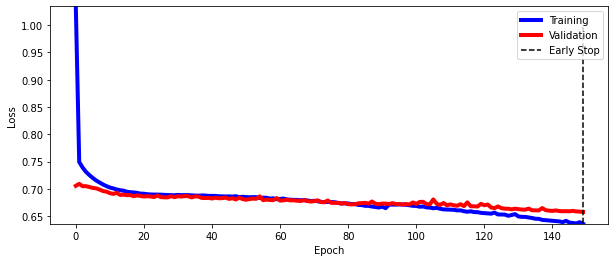

In [30]:
plot_learning_curve(history_one_filter)

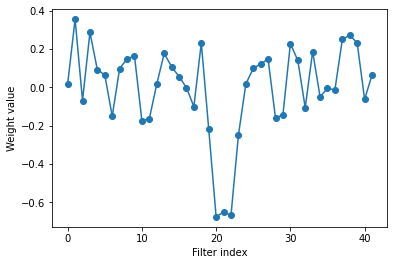

(<Figure size 432x288 with 1 Axes>,
 [<AxesSubplot:xlabel='Filter index', ylabel='Weight value'>])

In [31]:
plot_model_weights(one_filter_keras_model)

Plotting simulation motifs...


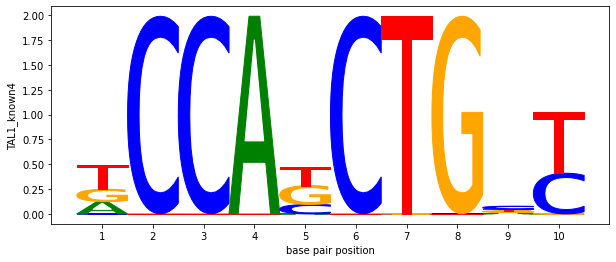

Visualizing convolutional sequence filters in SequenceDNN...


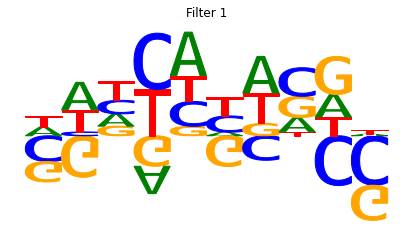

In [32]:
plot_filters(one_filter_keras_model, simulation_data)

In [33]:
multi_filter_keras_model = Sequential()
multi_filter_keras_model.add(
    Conv2D(filters=15, kernel_size=(1,10), padding="same", input_shape=simulation_data.X_train.shape[1::])
)
multi_filter_keras_model.add(BatchNormalization(axis=-1))
multi_filter_keras_model.add(Activation('relu'))
multi_filter_keras_model.add(MaxPooling2D(pool_size=(1, 35)))
multi_filter_keras_model.add(Flatten())
multi_filter_keras_model.add(Dense(1))
multi_filter_keras_model.add(Activation("sigmoid"))

In [34]:
multi_filter_keras_model.compile(optimizer="adam", loss="binary_crossentropy")

In [35]:
multi_filter_keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 1500, 15)       615       
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1500, 15)       60        
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1500, 15)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 42, 15)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 630)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 631       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                

In [36]:
history_multi_filter = multi_filter_keras_model.fit(x=simulation_data.X_train,
                                               y=simulation_data.y_train,
                                               batch_size=128,
                                               epochs=100,
                                               verbose=1,
                                               callbacks=[EarlyStopping(patience=20, restore_best_weights=True),
                                                         History(),
                                                         metrics_callback],
                                               validation_data=(simulation_data.X_valid, simulation_data.y_valid))

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 2s 557us/step - loss: 0.8508 - val_loss: 0.6976
Training Data:
Loss: 0.6964	Balanced Accuracy: 51.25%	 auROC: 0.530	 auPRC Careful: 0.528	 auPRC Trapezoidal: 0.527
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6976	Balanced Accuracy: 52.07%	 auROC: 0.542	 auPRC Careful: 0.515	 auPRC Trapezoidal: 0.513
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 481	 Num Negatives: 519
Epoch 2/100
4000/4000 [==============================] - 2s 524us/step - loss: 0.7209 - val_loss: 0.6902
Training Data:
Loss: 0.6881	Balanced Accuracy: 54.14%	 auROC: 0.561	 auPRC Careful: 0.553	 auPRC Trapezoidal: 0.552
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.6902	Balanced Accuracy: 52.79%	 auROC: 0.556	 auPRC Careful: 0.527	 auPRC Trapezoidal: 0.525
	Recall at 5%|10%|20% FD

4000/4000 [==============================] - 2s 533us/step - loss: 0.2547 - val_loss: 0.2685
Training Data:
Loss: 0.2471	Balanced Accuracy: 92.41%	 auROC: 0.981	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 88.2%|95.6%|99.6%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.2685	Balanced Accuracy: 91.54%	 auROC: 0.972	 auPRC Careful: 0.967	 auPRC Trapezoidal: 0.967
	Recall at 5%|10%|20% FDR: 79.2%|92.9%|98.5%	 Num Positives: 481	 Num Negatives: 519
Epoch 18/100
4000/4000 [==============================] - 2s 619us/step - loss: 0.2416 - val_loss: 0.2545
Training Data:
Loss: 0.2336	Balanced Accuracy: 92.70%	 auROC: 0.982	 auPRC Careful: 0.981	 auPRC Trapezoidal: 0.981
	Recall at 5%|10%|20% FDR: 88.7%|96.2%|99.6%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.2545	Balanced Accuracy: 91.08%	 auROC: 0.974	 auPRC Careful: 0.969	 auPRC Trapezoidal: 0.969
	Recall at 5%|10%|20% FDR: 80.7%|93.3%|98.8%	 Num Positives: 481	 Num Nega

4000/4000 [==============================] - 2s 567us/step - loss: 0.1574 - val_loss: 0.1961
Training Data:
Loss: 0.1620	Balanced Accuracy: 93.88%	 auROC: 0.991	 auPRC Careful: 0.991	 auPRC Trapezoidal: 0.991
	Recall at 5%|10%|20% FDR: 94.8%|99.1%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1961	Balanced Accuracy: 91.84%	 auROC: 0.982	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 89.8%|96.5%|99.6%	 Num Positives: 481	 Num Negatives: 519
Epoch 34/100
4000/4000 [==============================] - 2s 542us/step - loss: 0.1512 - val_loss: 0.1814
Training Data:
Loss: 0.1455	Balanced Accuracy: 94.93%	 auROC: 0.992	 auPRC Careful: 0.991	 auPRC Trapezoidal: 0.991
	Recall at 5%|10%|20% FDR: 95.1%|99.1%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1814	Balanced Accuracy: 93.67%	 auROC: 0.982	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 89.8%|96.5%|99.6%	 Num Positives: 481	 Num Ne

4000/4000 [==============================] - 2s 553us/step - loss: 0.1213 - val_loss: 0.1713
Training Data:
Loss: 0.1171	Balanced Accuracy: 96.08%	 auROC: 0.995	 auPRC Careful: 0.994	 auPRC Trapezoidal: 0.994
	Recall at 5%|10%|20% FDR: 97.6%|99.8%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1713	Balanced Accuracy: 92.83%	 auROC: 0.983	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 90.0%|96.9%|99.8%	 Num Positives: 481	 Num Negatives: 519
Epoch 50/100
4000/4000 [==============================] - 2s 596us/step - loss: 0.1177 - val_loss: 0.1699
Training Data:
Loss: 0.1137	Balanced Accuracy: 96.15%	 auROC: 0.995	 auPRC Careful: 0.995	 auPRC Trapezoidal: 0.995
	Recall at 5%|10%|20% FDR: 97.7%|99.8%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1699	Balanced Accuracy: 93.27%	 auROC: 0.983	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 89.0%|96.5%|99.8%	 Num Positives: 481	 Num Ne

4000/4000 [==============================] - 2s 572us/step - loss: 0.0964 - val_loss: 0.1750
Training Data:
Loss: 0.1023	Balanced Accuracy: 96.57%	 auROC: 0.997	 auPRC Careful: 0.997	 auPRC Trapezoidal: 0.997
	Recall at 5%|10%|20% FDR: 99.2%|100.0%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1750	Balanced Accuracy: 93.20%	 auROC: 0.983	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 90.0%|96.3%|99.6%	 Num Positives: 481	 Num Negatives: 519
Epoch 66/100
4000/4000 [==============================] - 2s 622us/step - loss: 0.1017 - val_loss: 0.1668
Training Data:
Loss: 0.0923	Balanced Accuracy: 97.40%	 auROC: 0.997	 auPRC Careful: 0.997	 auPRC Trapezoidal: 0.997
	Recall at 5%|10%|20% FDR: 99.2%|100.0%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1668	Balanced Accuracy: 93.26%	 auROC: 0.983	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 90.2%|96.0%|99.6%	 Num Positives: 481	 Num 

4000/4000 [==============================] - 2s 540us/step - loss: 0.0816 - val_loss: 0.1786
Training Data:
Loss: 0.0843	Balanced Accuracy: 97.36%	 auROC: 0.998	 auPRC Careful: 0.998	 auPRC Trapezoidal: 0.998
	Recall at 5%|10%|20% FDR: 99.7%|100.0%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1786	Balanced Accuracy: 92.68%	 auROC: 0.983	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 90.4%|95.0%|99.6%	 Num Positives: 481	 Num Negatives: 519
Epoch 82/100
4000/4000 [==============================] - 2s 537us/step - loss: 0.0802 - val_loss: 0.1665
Training Data:
Loss: 0.0749	Balanced Accuracy: 98.14%	 auROC: 0.998	 auPRC Careful: 0.998	 auPRC Trapezoidal: 0.998
	Recall at 5%|10%|20% FDR: 99.8%|100.0%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1665	Balanced Accuracy: 93.48%	 auROC: 0.983	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 90.4%|96.3%|99.6%	 Num Positives: 481	 Num 

4000/4000 [==============================] - 2s 537us/step - loss: 0.0899 - val_loss: 0.1662
Training Data:
Loss: 0.0856	Balanced Accuracy: 97.80%	 auROC: 0.998	 auPRC Careful: 0.997	 auPRC Trapezoidal: 0.997
	Recall at 5%|10%|20% FDR: 99.4%|100.0%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1648	Balanced Accuracy: 93.38%	 auROC: 0.983	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 90.0%|96.0%|99.4%	 Num Positives: 481	 Num Negatives: 519
Epoch 98/100
4000/4000 [==============================] - 2s 537us/step - loss: 0.0899 - val_loss: 0.1669
Training Data:
Loss: 0.0856	Balanced Accuracy: 97.80%	 auROC: 0.998	 auPRC Careful: 0.997	 auPRC Trapezoidal: 0.997
	Recall at 5%|10%|20% FDR: 99.4%|100.0%|100.0%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.1648	Balanced Accuracy: 93.38%	 auROC: 0.983	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 90.0%|96.0%|99.4%	 Num Positives: 481	 Num 

In [37]:
test_predictions = multi_filter_keras_model.predict(simulation_data.X_test)
print(ClassificationResult(simulation_data.y_test, test_predictions))

Loss: 0.1915	Balanced Accuracy: 91.70%	 auROC: 0.977	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 84.0%|97.0%|99.6%	 Num Positives: 501	 Num Negatives: 499


In [38]:
%matplotlib inline

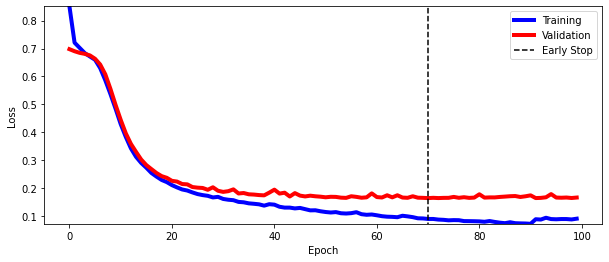

In [39]:
plot_learning_curve(history_multi_filter)

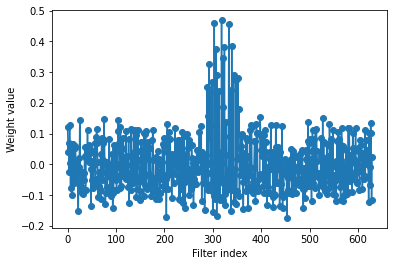

(<Figure size 432x288 with 1 Axes>,
 [<AxesSubplot:xlabel='Filter index', ylabel='Weight value'>])

In [54]:
plot_model_weights(multi_filter_keras_model)

Plotting simulation motifs...


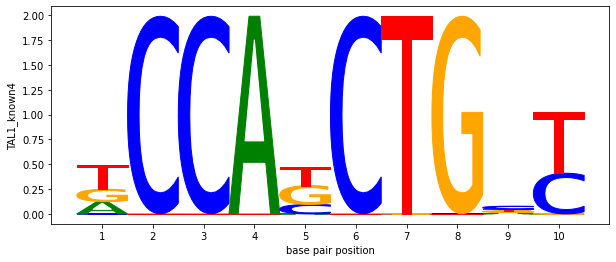

Visualizing convolutional sequence filters in SequenceDNN...


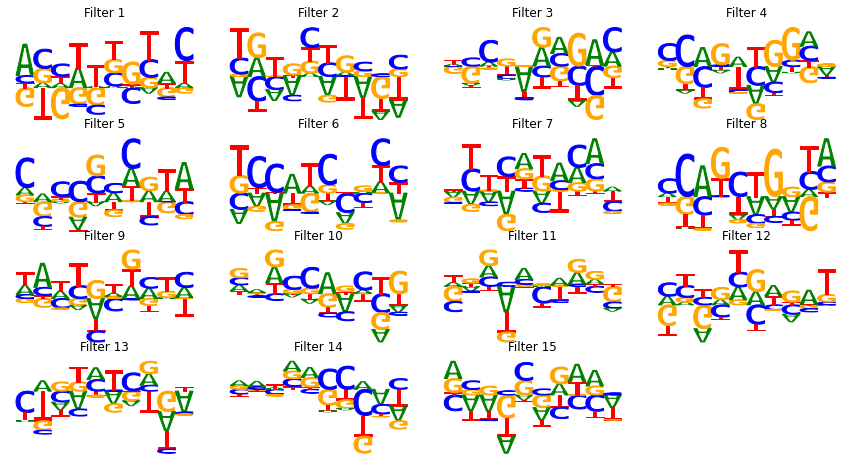

In [55]:
plot_filters(multi_filter_keras_model, simulation_data)

In [56]:
pos_indx = np.flatnonzero(simulation_data.y_valid==1)[0]
print(pos_indx)
pos_X = simulation_data.X_valid[pos_indx:pos_indx+1]

2


In [57]:
neg_indx = np.flatnonzero(simulation_data.y_valid==0)[10]
print(neg_indx)
neg_X = simulation_data.X_valid[neg_indx:neg_indx+1]

20


In [58]:
pos_motif_scores = get_motif_scores(pos_X, simulation_data.motif_names, return_positions=True)
neg_motif_scores = get_motif_scores(neg_X, simulation_data.motif_names, return_positions=True)

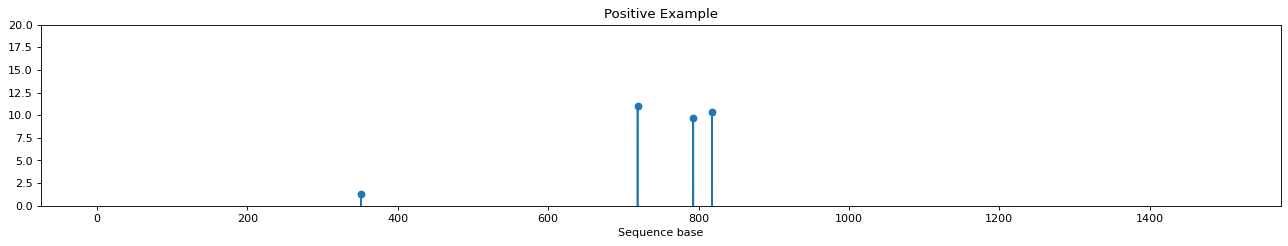

In [59]:
plot_motif_scores(pos_motif_scores, title="Positive Example", ylim=(0, 20))

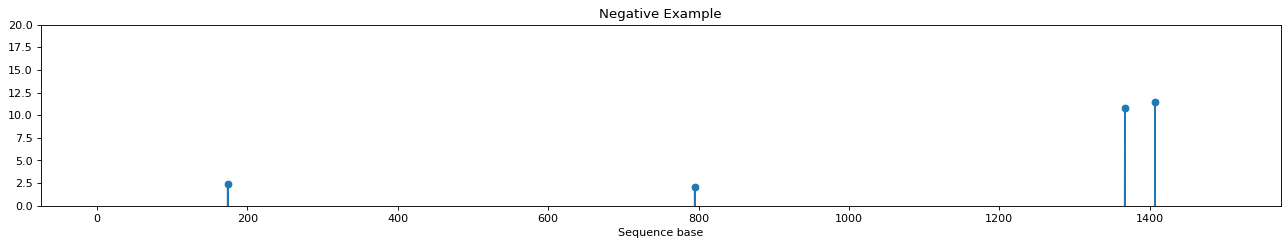

In [60]:
plot_motif_scores(neg_motif_scores, title="Negative Example", ylim=(0, 20))

In [61]:
ism_pos = in_silico_mutagenesis(multi_filter_keras_model, pos_X, 0)
ism_neg = in_silico_mutagenesis(multi_filter_keras_model, neg_X, 0)

ISM: task:0 sample:0
ISM: task:0 sample:0


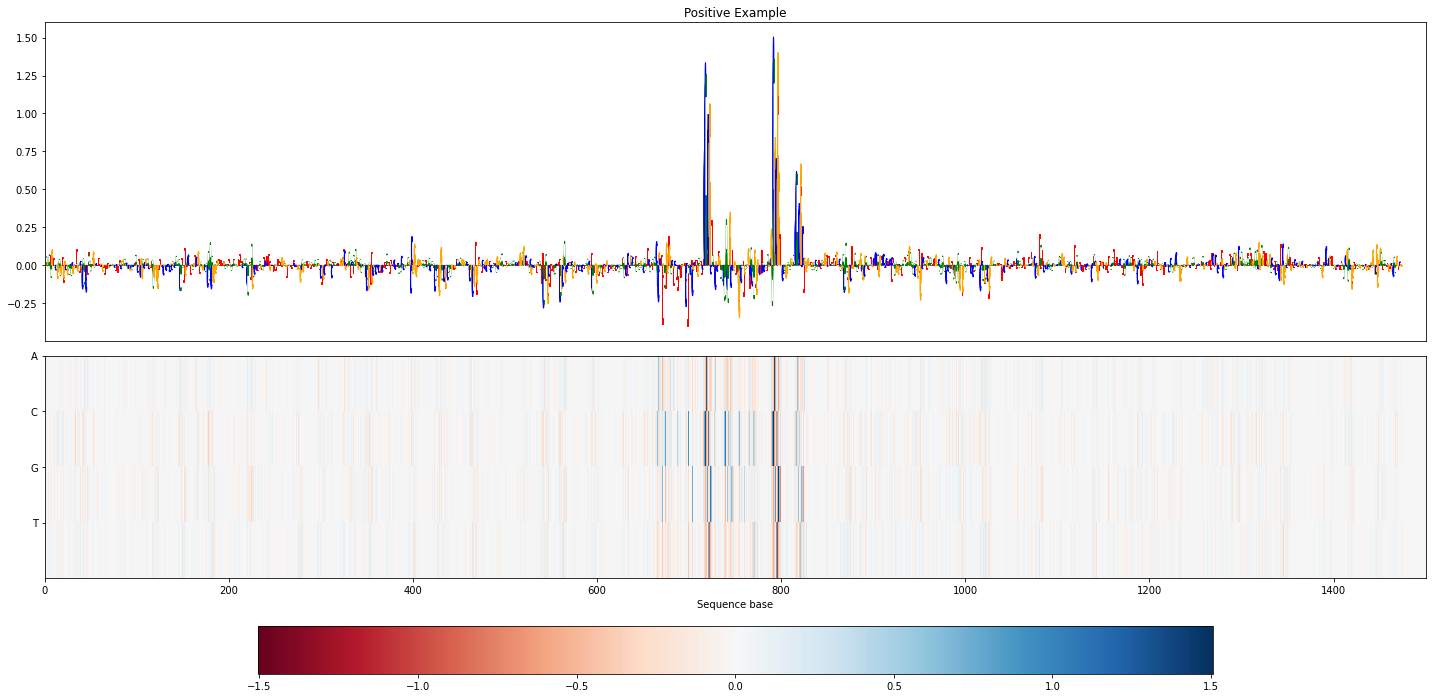

In [62]:
plot_ism(ism_pos, pos_X, title='Positive Example')

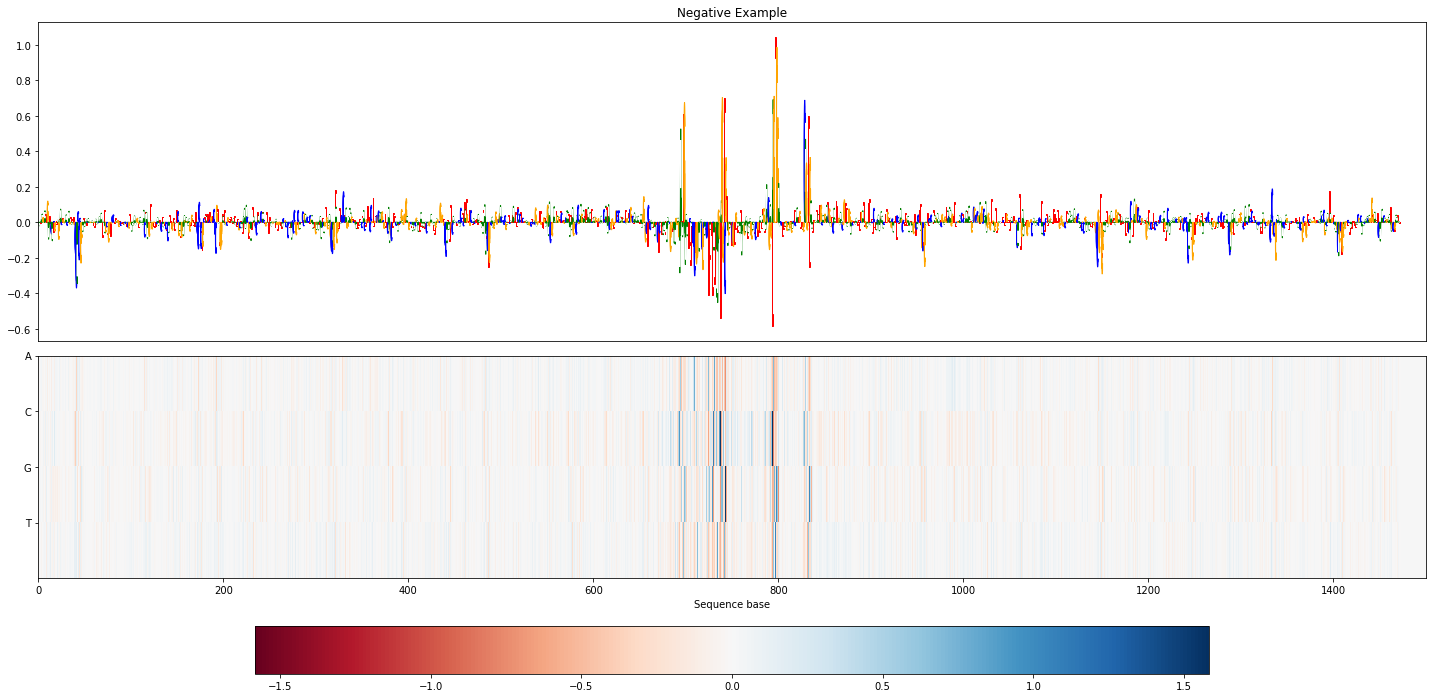

In [63]:
plot_ism(ism_neg, neg_X, title='Negative Example')

In [64]:
gradinput_pos = input_grad(multi_filter_keras_model, pos_X)
gradinput_neg = input_grad(multi_filter_keras_model, neg_X)

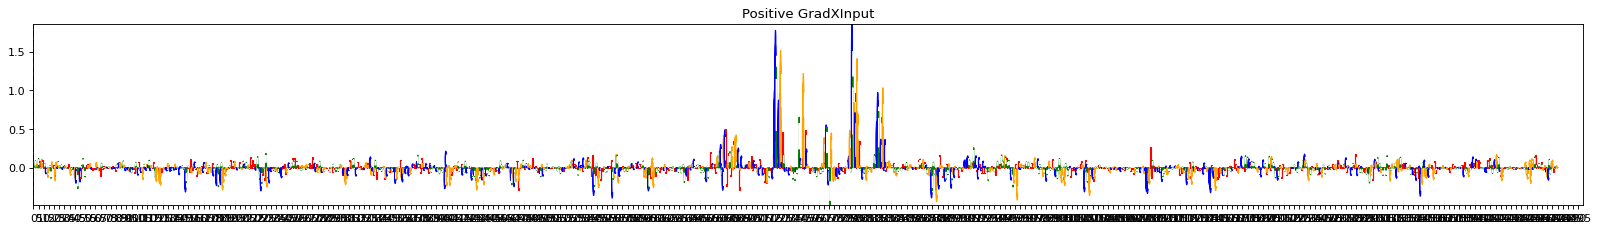

In [65]:
plot_seq_importance(gradinput_pos, pos_X, title="Positive GradXInput")

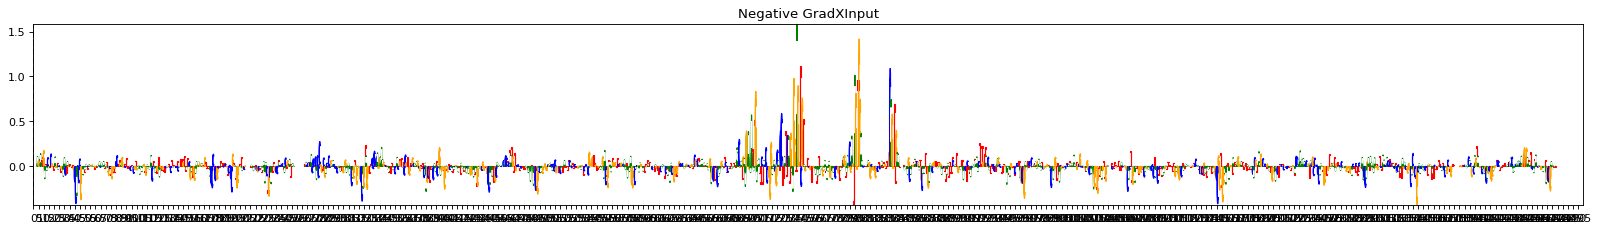

In [66]:
plot_seq_importance(gradinput_neg, neg_X, title="Negative GradXInput")

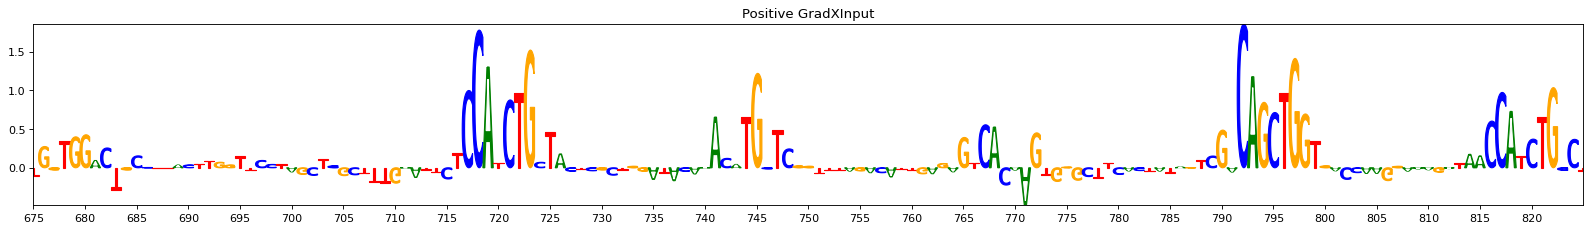

In [67]:
plot_seq_importance(gradinput_pos, pos_X, title="Positive GradXInput", xlim=(675, 825))

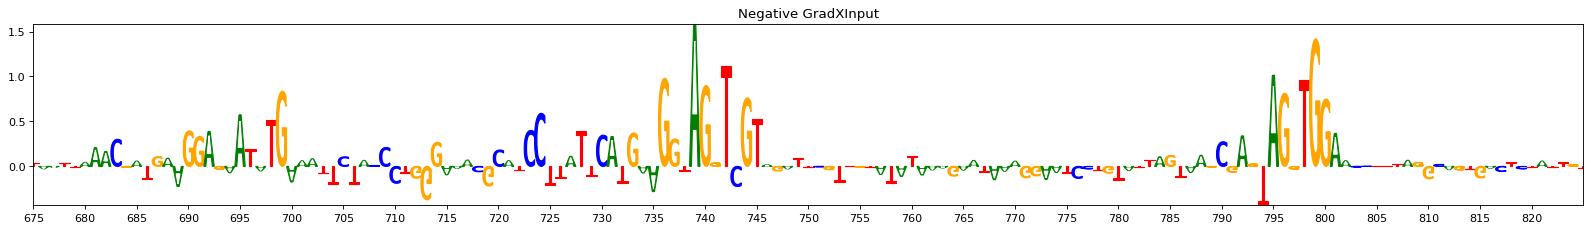

In [68]:
plot_seq_importance(gradinput_neg, neg_X, title="Negative GradXInput", xlim=(675, 825))

In [69]:
multi_filter_keras_model.save("tut1_multi_filter_keras_model.hdf5")

In [70]:
model = load_model("tut1_multi_filter_keras_model.hdf5")

In [71]:
dl_score_func = get_deeplift_scoring_function('tut1_multi_filter_keras_model.hdf5',
                                             target_layer_idx=-2,
                                             task_idx=0,
                                             num_refs_per_seq=10,
                                             reference='shuffled_ref',
                                             one_hot_func=None)

In [73]:
dl_pos = deeplift(dl_score_func, pos_X)

In [74]:
dl_neg = deeplift(dl_score_func, neg_X)

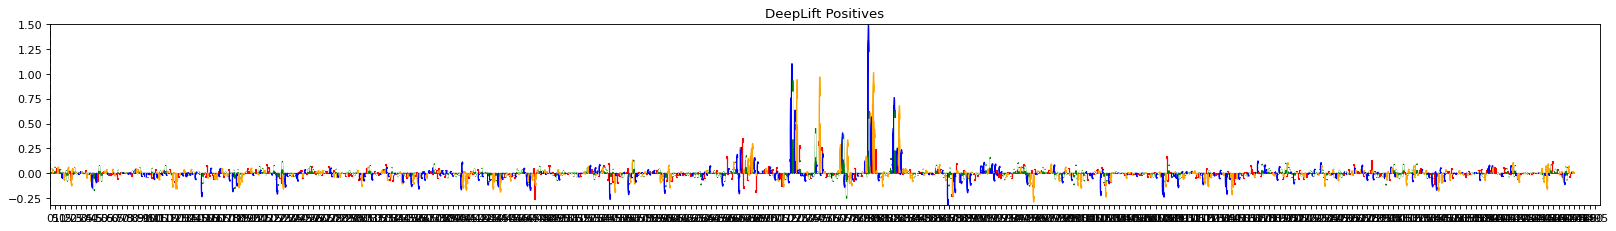

In [76]:
plot_seq_importance(dl_pos, pos_X, title="DeepLift Positives")

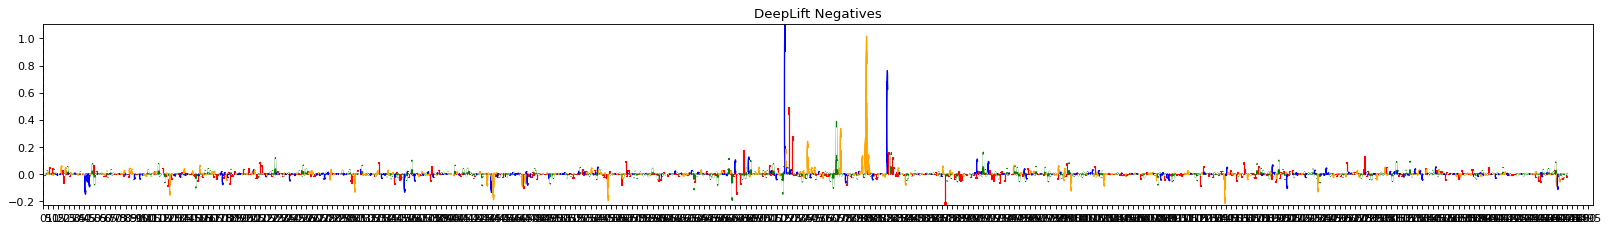

In [77]:
plot_seq_importance(dl_pos, neg_X, title="DeepLift Negatives")

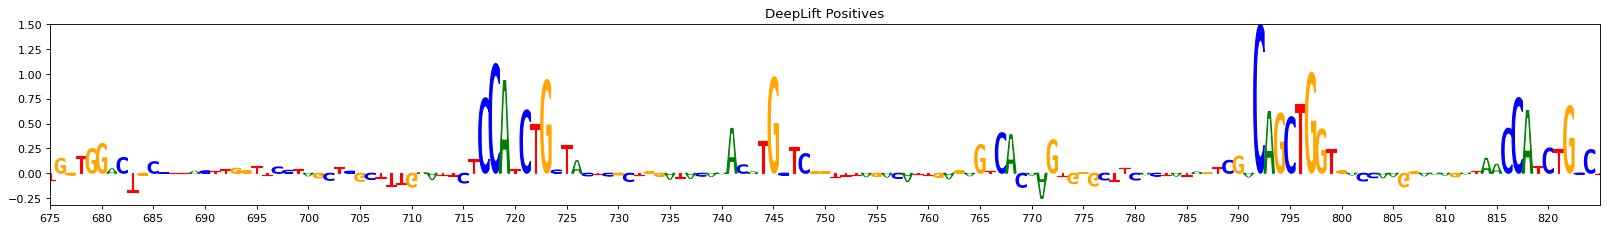

In [78]:
plot_seq_importance(dl_pos, pos_X, title="DeepLift Positives", xlim=(675,825))

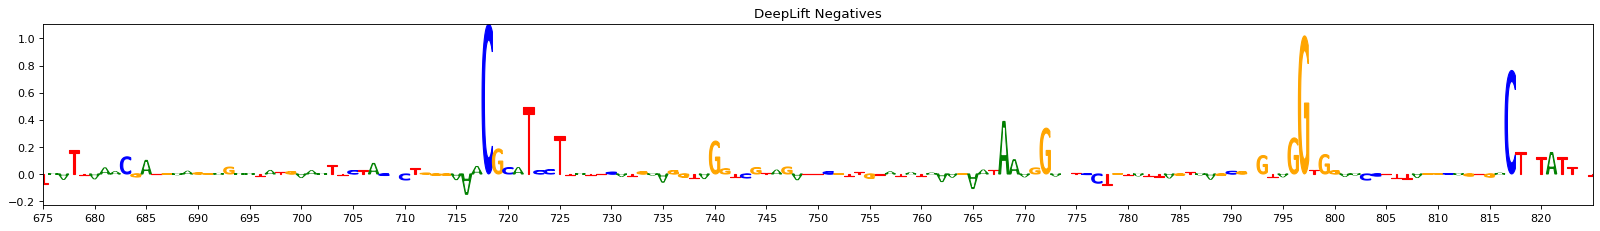

In [79]:
plot_seq_importance(dl_pos, neg_X, title="DeepLift Negatives", xlim=(675,825))